In [1]:
import math
import random
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import Model

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

In [5]:
train_dir = f"..\\data\\tr"
time = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

In [6]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

In [7]:
FILE_NAMES = ['combinedneg.txt', 'combinedneut2.txt', 'combinedpos.txt']
labeled_data_sets = []
# Give labels to the data, 0 for negatives, 1 for neutrals, 2 for positives.
for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(f"{train_dir}\\{file_name}")
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)

In [9]:
BUFFER_SIZE = 50000
# concatenate all labeled datasets into one and shuffle
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

In [10]:
DATASET_SIZE = [i for i,_ in enumerate(all_labeled_data)][-1] + 1
BATCH_SIZE = 32
VALIDATION_SIZE = math.ceil(DATASET_SIZE * 0.1)
VOCAB_SIZE = 45000

In [11]:
print('Labels are 0 = negative, 1 = neutral, 2 = positive.\n')
for text, label in all_labeled_data.take(1):
    print("Sentence: ", text.numpy())
    print("Label:", label.numpy())

Labels are 0 = negative, 1 = neutral, 2 = positive.

Sentence:  b'ly\xc3\xb6 h\xc3\xa4nt\xc3\xa4, is\xc3\xa4.'
Label: 0


In [12]:
train_dataset = all_labeled_data.skip(VALIDATION_SIZE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = all_labeled_data.take(VALIDATION_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])
encoder = TextVectorization()
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary())
print(len(vocab), vocab[:20])
encoded_example = encoder(example)[:3].numpy()
print(encoded_example)
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

texts:  [b'kirkossa olevien uskovien tulisi nyt korottaa \xc3\xa4\xc3\xa4nens\xc3\xa4 ja uskaltaa kertoa oma n\xc3\xa4kemyksens\xc3\xa4 yleisest\xc3\xa4 mielipiteens\xc3\xa4 huolimatta.'
 b'mutta hyv\xc3\xa4\xc3\xa4 p\xc3\xa4iv\xc3\xa4njatkoa ja hymy\xc3\xa4 huuleen.'
 b'kale on jo kertaalleen h\xc3\xa4vinnyt eli pois potkittu.']

labels:  [1 2 1]
54760 ['' '[UNK]' 'on' 'ja' 'ei' 'että' 'se' 'ole' 'en' 'mutta' 'kun' 'niin'
 'jos' 'hän' 'olen' 'mitä' 'oli' 'voi' 'kuin' 'nyt']
[[ 3327  5812  2690   375    19  3907  6605     3  6919   378   228 34621
  17830  3258  1189     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [    9   117  7598     3  4914 47620     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [44846     2    33 15005  4907    77    98 31

In [14]:
import pickle
with open("..\\data\\others\\vocab2.pickle", "wb") as output_file:
    pickle.dump(vocab, output_file)

In [21]:
def create_model(num_labels):
    model_layers = tf.keras.Sequential([
        encoder,
        layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=64, embeddings_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), mask_zero=True),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dropout(0.20),
        layers.Dense(32, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), activation='relu'),
        layers.Dropout(0.20),
        layers.Dense(num_labels),
        layers.Activation('softmax')])
    return model_layers

In [22]:
model = create_model(num_labels=3)
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=1)
model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=test_dataset, callbacks=[early_stop], epochs=15)
model.summary()

Epoch 1/15
979/979 [==============================] - 90s 73ms/step - loss: 1.2269 - accuracy: 0.5011 - val_loss: 0.9615 - val_accuracy: 0.5320
Epoch 2/15
979/979 [==============================] - 69s 71ms/step - loss: 0.8926 - accuracy: 0.6012 - val_loss: 0.8598 - val_accuracy: 0.6360
Epoch 3/15
979/979 [==============================] - 69s 70ms/step - loss: 0.7506 - accuracy: 0.7153 - val_loss: 0.8158 - val_accuracy: 0.6903
Epoch 4/15
979/979 [==============================] - 70s 71ms/step - loss: 0.5921 - accuracy: 0.8144 - val_loss: 0.8283 - val_accuracy: 0.7107
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 64)          3504640   
_________________________________________________________________
bidire

In [23]:
# model.save(f'model/rnn_{time}.h5')
model.save(f'model/rnn_{time}')

INFO:tensorflow:Assets written to: model/rnn_15-07-2021_15-22-35\assets


INFO:tensorflow:Assets written to: model/rnn_15-07-2021_15-22-35\assets


In [24]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

109/109 [==============================] - 4s 29ms/step - loss: 0.8283 - accuracy: 0.7107
Test Loss: 0.8282654881477356
Test Accuracy: 0.7107152938842773


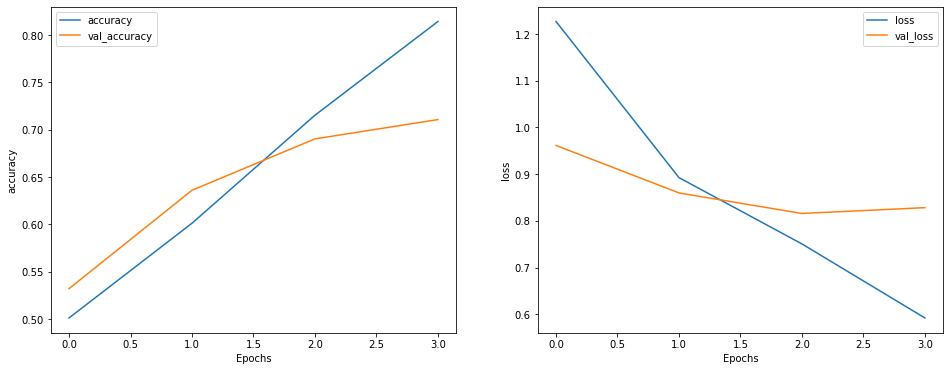

In [25]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [26]:
modelpath = f"model/rnn_{time}"
import_model = tf.keras.models.load_model(modelpath)
import_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 64)          3504640   
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)               

In [27]:
n = 5
inputs = []
with open(f"D:\\Work\\Data\\s24_2001_sentences_shuffled_slice.txt", 'r', encoding='utf-8') as f:
    lines = f.readlines()
    random.shuffle(lines)
    for line in lines:
        inputs.append(line.strip('\n'))
inputs = np.array(inputs[:n])
print(inputs[:n])

['3. pieneen akvaarioon tehoaa kun kesäisin laitat sinne jääpaloja...'
 'mä olen suuri pokemonfani.et sä sit vai oo??? '
 'Saisivat siten omistajat toteuttaa näitä pissa fantasioitaan omissa oloissaan. '
 'Tuoreruoka pitää olla hyvin pestyä ja kuivattua. '
 'Ei ole ollut enää lukukuntoinen (koiramme lehdessä mainittu) ja kuinka monta niitä siruja voikaan koiraan laittaa??! ']


In [28]:
def make_prediction(inps):
    predicted_scores = import_model.predict(np.array(inps))
    predicted_labels = tf.argmax(predicted_scores, axis=1)
    lab, pred = '', ''
    labs, preds = [], []
    for i, (inp, label) in enumerate(zip(inputs, predicted_labels)):
        pred = (', '.join(f'{q:.5f}' for q in predicted_scores[i]))
        lab = label.numpy()
        print(f"Sentence: {inp}")
        print(f"Predicted label: {lab}")
        print(f"Predicted probs: {pred}\n")
        labs.append(lab)
        preds.append(pred)
    return labs, preds

print(np.array(inputs), '\n\n', make_prediction(inputs))

Sentence: 3. pieneen akvaarioon tehoaa kun kesäisin laitat sinne jääpaloja...
Predicted label: 1
Predicted probs: 0.00067, 0.98367, 0.01566

Sentence: mä olen suuri pokemonfani.et sä sit vai oo??? 
Predicted label: 0
Predicted probs: 0.94570, 0.04454, 0.00976

Sentence: Saisivat siten omistajat toteuttaa näitä pissa fantasioitaan omissa oloissaan. 
Predicted label: 1
Predicted probs: 0.00524, 0.96583, 0.02892

Sentence: Tuoreruoka pitää olla hyvin pestyä ja kuivattua. 
Predicted label: 1
Predicted probs: 0.16357, 0.64734, 0.18909

Sentence: Ei ole ollut enää lukukuntoinen (koiramme lehdessä mainittu) ja kuinka monta niitä siruja voikaan koiraan laittaa??! 
Predicted label: 1
Predicted probs: 0.00076, 0.98496, 0.01428

['3. pieneen akvaarioon tehoaa kun kesäisin laitat sinne jääpaloja...'
 'mä olen suuri pokemonfani.et sä sit vai oo??? '
 'Saisivat siten omistajat toteuttaa näitä pissa fantasioitaan omissa oloissaan. '
 'Tuoreruoka pitää olla hyvin pestyä ja kuivattua. '
 'Ei ole ollut 

In [29]:
inputs2 = [
    "haista sinä kuka sitten ootkin iso ja haiseva vittu!",  # Label: 0
    "Minun mielestäni asiattomiin kirjoituksiin ei kannata koskaan vastata mitään. ",  # Label: 1
    "Ihana kuulla et sulla menee hyvin, olen onnellinen sinun puolestasi =) Oikeesti!"  # Label: 2
]
make_prediction(inputs2)
print(np.array(inputs), make_prediction(inputs))

Sentence: 3. pieneen akvaarioon tehoaa kun kesäisin laitat sinne jääpaloja...
Predicted label: 0
Predicted probs: 0.99803, 0.00173, 0.00024

Sentence: mä olen suuri pokemonfani.et sä sit vai oo??? 
Predicted label: 0
Predicted probs: 0.91525, 0.05497, 0.02978

Sentence: Saisivat siten omistajat toteuttaa näitä pissa fantasioitaan omissa oloissaan. 
Predicted label: 2
Predicted probs: 0.00366, 0.00012, 0.99623

Sentence: 3. pieneen akvaarioon tehoaa kun kesäisin laitat sinne jääpaloja...
Predicted label: 1
Predicted probs: 0.00067, 0.98367, 0.01566

Sentence: mä olen suuri pokemonfani.et sä sit vai oo??? 
Predicted label: 0
Predicted probs: 0.94570, 0.04454, 0.00976

Sentence: Saisivat siten omistajat toteuttaa näitä pissa fantasioitaan omissa oloissaan. 
Predicted label: 1
Predicted probs: 0.00524, 0.96583, 0.02892

Sentence: Tuoreruoka pitää olla hyvin pestyä ja kuivattua. 
Predicted label: 1
Predicted probs: 0.16357, 0.64734, 0.18909

Sentence: Ei ole ollut enää lukukuntoinen (koiram

In [30]:
inputs3 = [
    "Alkaa vituttamaan nuo saatanan rengasmainokset, jotka pomppii koko ajan silmille.", # Label: 0
    "Joka vitun asiassa ne vaan ajattelee seksiä ja haluaa vaan sitä.", # Label: 0
    "Mitä olit niin itserakas, nyt se sitten on mennyt päähäsi!", # Label: 0
    "Huumekuolemat johtuvat lähes poikkeuksetta ylianostuksista ja nekin kovien huumeiden kyseessäollen.", # Label: 1
    "Presidenttihän ei saa edustaa omaa poliittista vakaumustaan.",  # Label: 1
    "Lopulta voi käydä myös niin, että vaikka olettekin olleet yhdessä ja nauttineet keskenänne paljosta rakkaudesta,"
    " te ette ole enää oikeita kumppaneita seuraavaa vaihetta varten." # Label: 1
    "Tänäänkin kaipaan kainaloa, hymyäsi ja ennenkaikkea halaustasi pusuista puhumattakaan.",  # Label: 2
    "Saan rakastella ja rakastaa häntä jälleen, Laitan hyvää ruokaa ja hieron hartioita.", # Label: 2
    "Hyvää syksynjatkoa kaikille lukijoilleni ja kiitos kommenteistanne." # Label: 2    
]
make_prediction(inputs3)

Sentence: 3. pieneen akvaarioon tehoaa kun kesäisin laitat sinne jääpaloja...
Predicted label: 1
Predicted probs: 0.27235, 0.56117, 0.16648

Sentence: mä olen suuri pokemonfani.et sä sit vai oo??? 
Predicted label: 1
Predicted probs: 0.00057, 0.99079, 0.00864

Sentence: Saisivat siten omistajat toteuttaa näitä pissa fantasioitaan omissa oloissaan. 
Predicted label: 1
Predicted probs: 0.01473, 0.95456, 0.03071

Sentence: Tuoreruoka pitää olla hyvin pestyä ja kuivattua. 
Predicted label: 1
Predicted probs: 0.01437, 0.95806, 0.02758

Sentence: Ei ole ollut enää lukukuntoinen (koiramme lehdessä mainittu) ja kuinka monta niitä siruja voikaan koiraan laittaa??! 
Predicted label: 1
Predicted probs: 0.08245, 0.90322, 0.01433



([1, 1, 1, 1, 1],
 ['0.27235, 0.56117, 0.16648',
  '0.00057, 0.99079, 0.00864',
  '0.01473, 0.95456, 0.03071',
  '0.01437, 0.95806, 0.02758',
  '0.08245, 0.90322, 0.01433'])